## This is my take at building a classification model to predict whether a given passenger will survive the tragedy on the RMS Titanic ##  
* The data was downloaded from the [Titanic: Machine Learning from Disaster](https://www.kaggle.com/c/titanic) page on Kaggle.  
Let's get started with the analysis. 

In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
% matplotlib inline
%config InlineBackend.figure_format = 'retina'
warnings.simplefilter("ignore")

In [37]:
# Read in the training and test dataset and concatenate them together
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
## Merge the test and training datasets togetjer
df = pd.concat([train,test], sort=False)

In [38]:
print("How many records in the training dataset? - {}".format(len(train)))
print("How many columns in the training dataset? - {}".format(len(train.columns)))
print("How many records in the test dataset? - {}".format(len(test)))
print("How many columns in the test dataset? - {}".format(len(test.columns)))

How many records in the training dataset? - 891
How many columns in the training dataset? - 12
How many records in the test dataset? - 418
How many columns in the test dataset? - 11


Since the titanic dataset is mean to be an introduction to machine learning, there are a limited number of records with a handful of attributes. Let's take a quick peek at the dataset.  
The reason we concatenated the dataset is to ensure that we don't have any missing values in our test dataset. Interesting side note: The test dataset is approximately a 30% split of the full concatenated dataset.

In [39]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### Let's quickly go over each of the 12 attributes and try to understand them. This is usually the most important and time-consuming step in building any machine learning model ####  
* 'PassengerId' is just a unique ID assigned to each passenger on board. For the purposes of our model, we could just ignore it. I am going to reset PassengerId as the index of the df.
* 'Survived' tells us whether or not a passenger survived the Titanic disaster (0=No, 1=Yes).
* 'Pclass' tells us the class in which the passenger traveled (1=1st Class, 2=2nd Class, 3=3rd Class)
* 'Name' is the name of the passenger.
* 'Sex' is the passenger's sex (male/female).
* 'Age' is the age of the passenger in years. It is fractional if less than one, and in the form xx.5 if estimated.
* 'SibSp' is the number of siblings or spouses on board (sibling includes stepbrother and stepsister).
* 'Parch' is the number of parents/children on board (Parch=0 for children that were only traveling with a nanny).
* 'Ticket' is the ticket number. For the purposes of this model, we could ignore this attribute as well.
* 'Fare' is the fare paid for a ticket on the RMS Titanic.
* 'Cabin' is the cabin number of the passenger. This is another attribute that could be ignored for the purposes of this model
* 'Embarked' is the port at which the passenger boarded the RMS Titanic (C = Cherbourg, Q = Queenstown, S = Southampton).  
Let's take a quick look at the number of missing values in the dataset:

In [40]:
df.set_index('PassengerId',drop=True,inplace=True)
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


   FeatureName  PercentMissValue
0     Survived         31.932773
1       Pclass          0.000000
2         Name          0.000000
3          Sex          0.000000
4          Age         20.091673
5        SibSp          0.000000
6        Parch          0.000000
7       Ticket          0.000000
8         Fare          0.076394
9        Cabin         77.463713
10    Embarked          0.152788


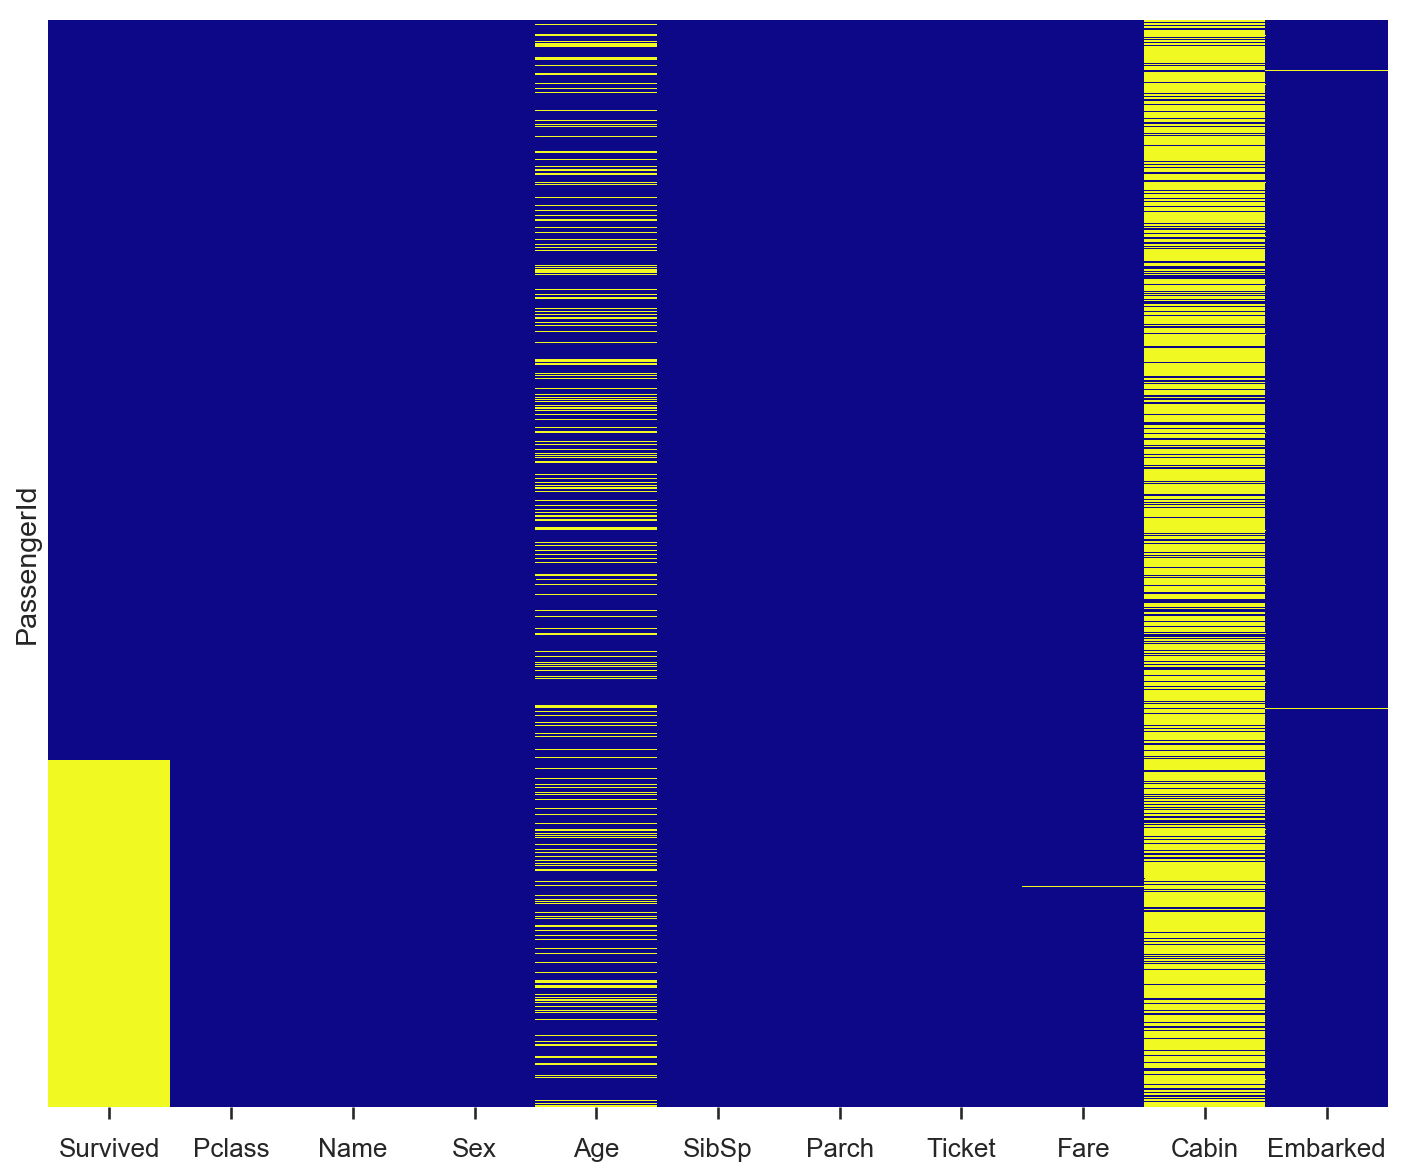

In [41]:
## Calculate percentage of missing value in each attribute
na_prop = (df.isnull().sum()/len(df))*100
## Convert the series to a pandas data frame
na_prop = pd.DataFrame({'FeatureName':na_prop.index,'PercentMissValue':na_prop.values})
print(na_prop)
## We could also visualize the missing data as a heatmap
plt.figure(figsize=(12,10))
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap="plasma")

## Imputing Missing Values ##
### Age ###  
Most of the columns seem to contain no missing values. However - Age, one of the more important columns that we will use for our model building contains a large percentage of missing values. Interestingly, the age attribute has missing values in the test data as well. Before we go ahead and figure out a strategy for imputing the missing values, let's take a look at a distribution of the age.

Text(0.5,1,'Distribution of Passenger Age aboard RMS Titanic')

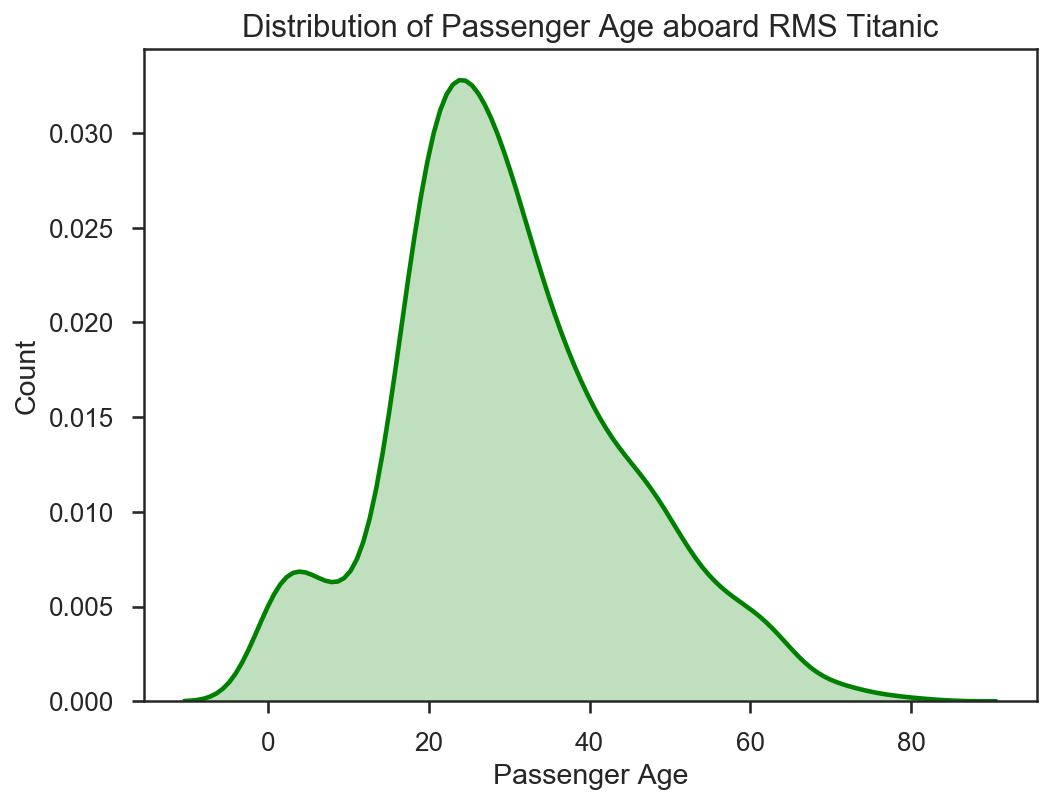

In [42]:
plt.figure(figsize=(8,6))
sns.set(style="ticks",context="talk")
sns.distplot(df['Age'], hist=False, color="g", kde_kws={'shade':True})
plt.xlabel("Passenger Age")
plt.ylabel("Count")
plt.title("Distribution of Passenger Age aboard RMS Titanic")

Plotting a distribution of the passenger age aboard the Titanic shows a distinct peak around 30 years. An easy way to deal with the missing values would be to substitute them with the median age. Could age be somehow correlated with the class in which the passenger traveled? 

Text(0.5,1,'Passenger Age by Class')

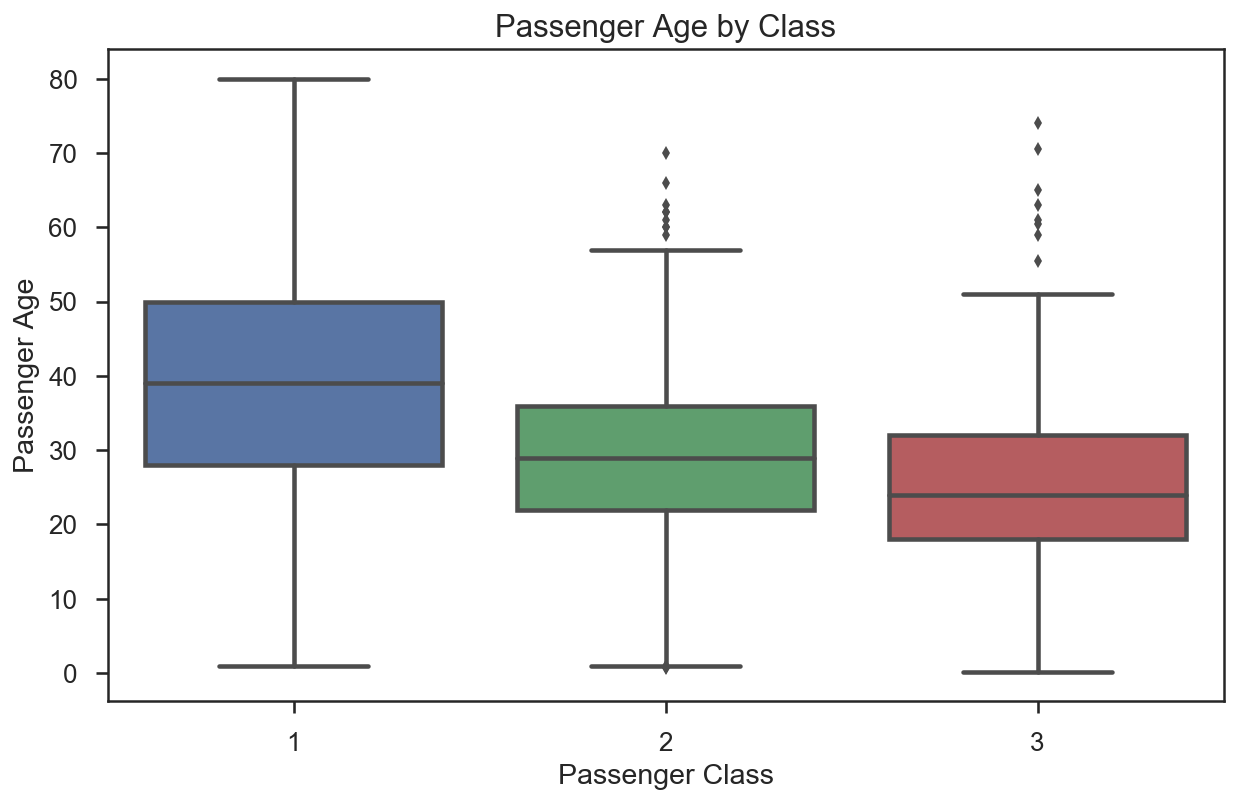

In [43]:
plt.figure(figsize=(10,6))
sns.set(style="ticks",context="talk")
sns.boxplot(x="Pclass", y="Age", data=df)
plt.ylabel("Passenger Age")
plt.xlabel("Passenger Class")
plt.title("Passenger Age by Class")

It appears as if the median age of the passenger is highly dependent on the class in which they traveled. Does it also depend on their sex, or where they embarked on the Titanic?

Text(0.5,1,'Age of Passenger by port of embarkation')

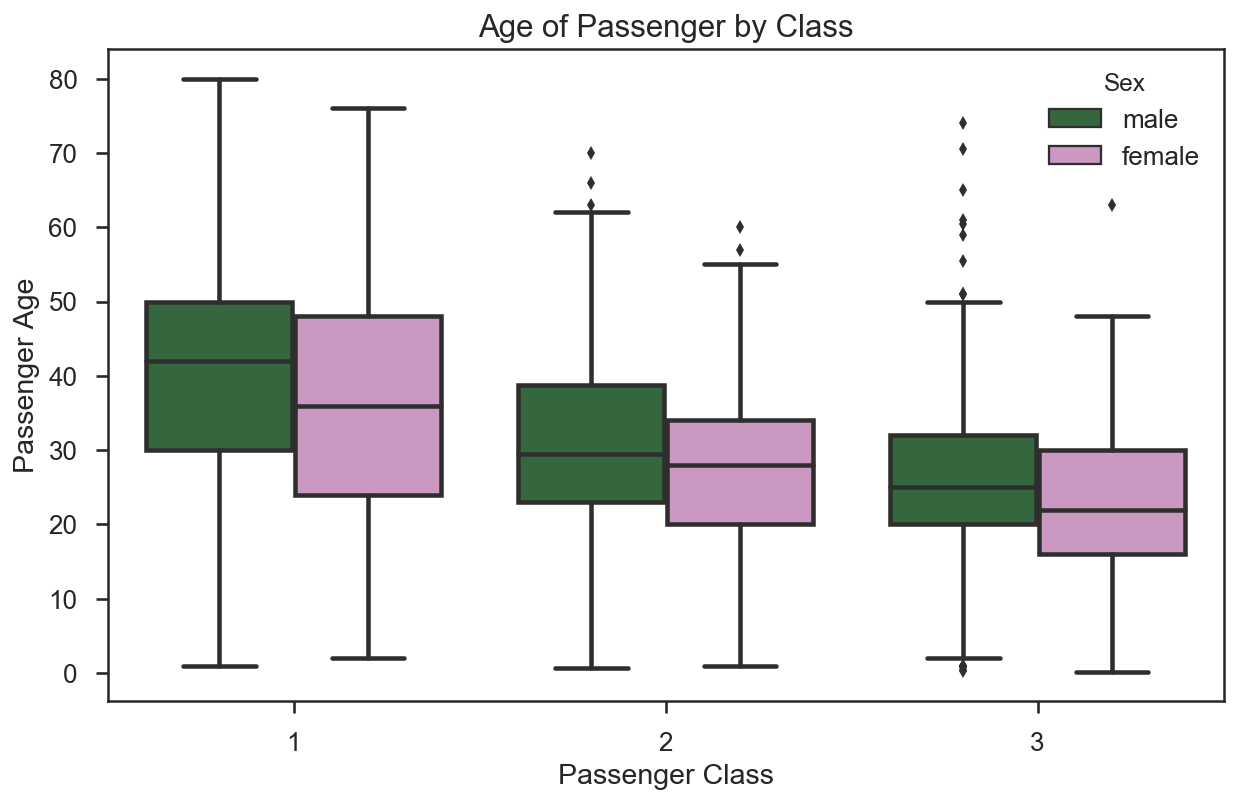

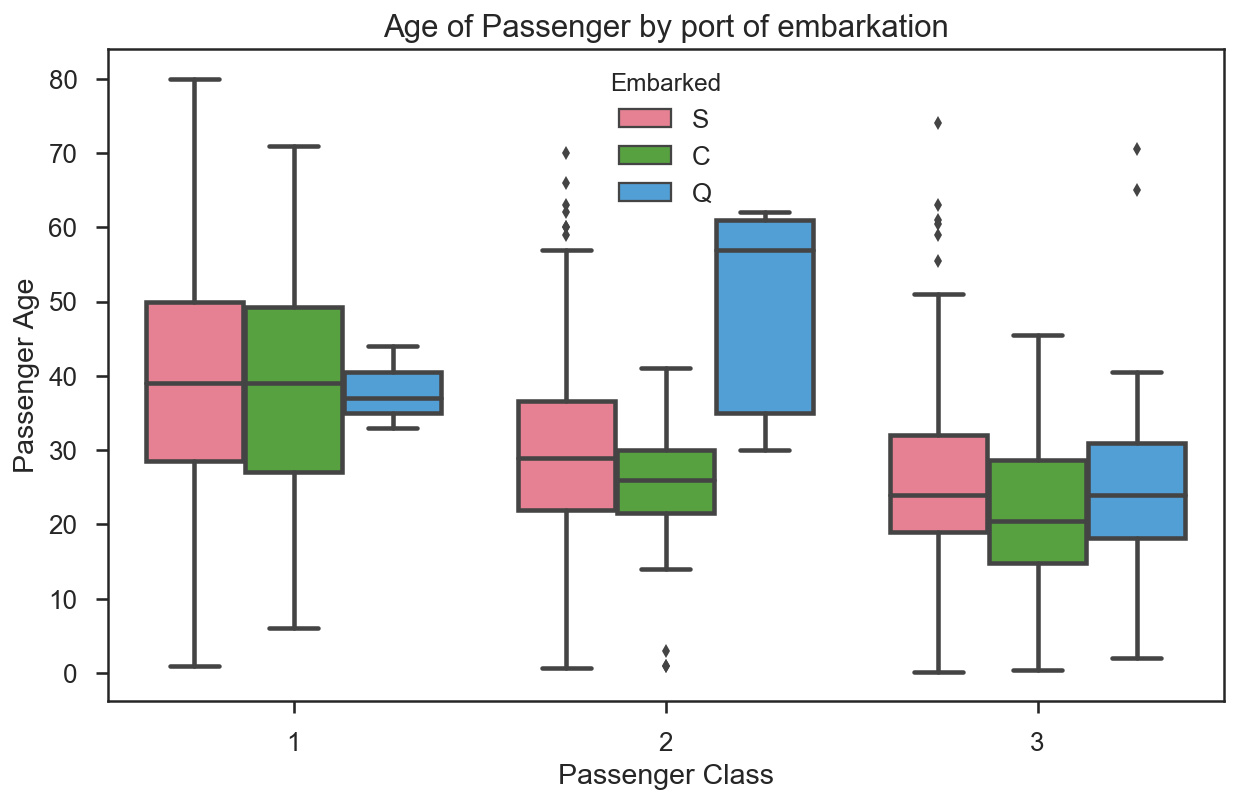

In [44]:
plt.figure(figsize=(10,6))

sns.set(style="ticks",context="talk")
sns.boxplot(x="Pclass", y="Age", hue="Sex" ,data=df, palette="cubehelix" )
plt.ylabel("Passenger Age")
plt.xlabel("Passenger Class")
plt.title("Age of Passenger by Class")

plt.figure(figsize=(10,6))
sns.set(style="ticks",context="talk")
sns.boxplot(x="Pclass", y="Age", hue="Embarked" ,data=df, palette="husl" )
plt.ylabel("Passenger Age")
plt.xlabel("Passenger Class")
plt.title("Age of Passenger by port of embarkation")

## Data Transformation ##
### Age ###
A passenger's age appears to largely be dependent on their sex and the class in which they were traveling. Age is largely independent of the port of embarkation, except in class 2, with passengers that embarked on the Titanic being older than passengers from Southampton or Cherbourg. However, using the port of embarkation as a factor to impute age is confounded by missing values in the embarked attribute itself.  
** I will be imputing the passenger's age based on their sex and the class in which they traveled. **

In [45]:
## Use a for loop to calculate median age for each passenger class by sez
med_age={}
for i in range(1,4):
    index_male = 'male' + str(i)
    index_female = 'female' + str(i)
    med_age[index_male] = df[(df['Sex']=='male') & (df['Pclass']==i)]['Age'].median()
    med_age[index_female] = df[(df['Sex']=='female') & (df['Pclass']==i)]['Age'].median()

## Define a function to replace the missing age values with the median values we just computed
def age_impute(cols):
    age = cols[0]
    Pclass = cols[1]
    sex = cols[2]
    if pd.isnull(age):
        return med_age[sex+str(Pclass)]
    else:
        return age

## Finally, let's replace the missing values in our data frame
df['Age'] = df[['Age','Pclass','Sex']].apply(age_impute, axis=1)

## Data Transformation ##
### Fare ###
Now that we have imputed the missing passenger age. Let's move on to the Fare attribute.  
There is only one missing value here, so I am going to just replace it with the median value in the group. Let's also take a look at a distribution of the fare.

Text(0.5,1,'Distribution of Passenger Fare')

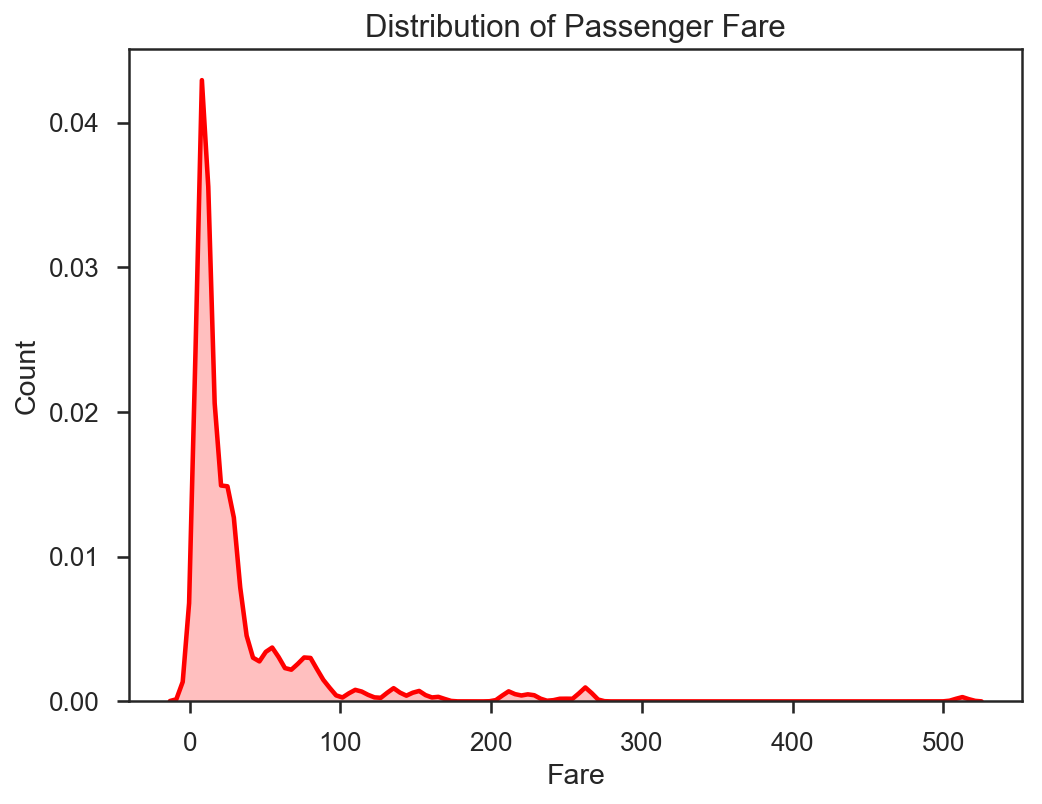

In [46]:
## Replace missing Fare value with the column median
df['Fare'].fillna(df['Fare'].median(),inplace=True)

## Plot a distribution of the Fare values
plt.figure(figsize=(8,6))
sns.set(style="ticks",context="talk")
sns.distplot(df['Fare'], hist=False, color="red", kde_kws={'shade':True})
plt.xlabel("Fare")
plt.ylabel("Count")
plt.title("Distribution of Passenger Fare")

The values for 'Fare' shows a distinct large peak close to 0 followed by multiple smaller peaks with a super long tail. Scaling the fare values will help with the model building.

In [47]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
df['Fare'] = std.fit_transform(df['Fare'].values.reshape(-1,1))

## Data Transformation ##
### Feature Encoding ###
I am going to use the 'get dummies' function in pandas to encode the categorical veriables. Here are the categorical variables that need to be encoded:
1. 'Sex'
2. 'Embarked'  
Also, I will drop the columns that are encoded. In addition,  attributes that will not be used for the model building will be dropped. The list includes:
1. 'Name'
2. 'Ticket'
3. 'Cabin'
4. 'Sex'
5. 'Embarked'
6. 'Survived' (becase that what we would like to predict)

In [48]:
## Encoding the Embarked attribute
df[['Embark_C', 'Embark_Q', 'Embark_S']] = pd.get_dummies(df['Embarked'])

## Encoding the sex attribute
df[['female','male']] = pd.get_dummies(df['Sex'])

## Dropping the attributes that are no longer needed
df.drop(['Name','Sex','Ticket','Cabin','Embarked'], axis=1, inplace=True)

The df is almost ready for model building. I am going to split the transformed dataset back into the respective training and test datasets. Finally, I will separate out the 'Survived' attribute in the training dataset to use for model building

In [49]:
## Splitting the df into training and test datasets
final_train = df.loc[df['Survived'].notnull()].copy()
final_test = df.loc[df['Survived'].isnull()].copy()

## Extract the 'Survived' column from the training dataset
final_train_y = final_train['Survived']
final_train_X = final_train.drop(['Survived'], axis=1)
final_test.drop(['Survived'], axis=1, inplace=True)

Now that the data is all cleaned up and ready to go. I can move on to model building. I will use the train_test_split module to split our training dataset into training and test datasets. This is done to enable model evaluation later on.

In [50]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(final_train_X, final_train_y, test_size=0.25, random_state=42)

## Logistic Regression ##
I will start by first building a logistic regression model and assessing its predictive accuracy.

In [51]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=42)
lr.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [52]:
## Predicting survival using logistic regression
predictions = lr.predict(X_test)

In [53]:
## Evaluating the predictions that were generated using the logistic regression model
from sklearn.metrics import confusion_matrix , classification_report
cm = confusion_matrix(y_test,predictions)
confmat = pd.DataFrame(data=cm, index=("Not Survived","Survived"), columns=("Not Survived","Survived"))
confmat

,Not Survived,Survived
Not Survived,116,18
Survived,25,64


In [54]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

        0.0       0.82      0.87      0.84       134
        1.0       0.78      0.72      0.75        89

avg / total       0.81      0.81      0.81       223



The logistic regression model performs resonably well (~80%) at predicting survival of passengers aboard the Titanic. It will be informative to see how a random forest classifier would perform in comparison to Logistic Regression.  
## Random Forest Classifier ##

In [55]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_jobs=8, random_state=42)
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=8,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [56]:
rfc_predictions = rfc.predict(X_test)

In [57]:
cm = confusion_matrix(y_test,rfc_predictions)
confmat = pd.DataFrame(data=cm, index=("Not Survived","Survived"), columns=("Not Survived","Survived"))
confmat

,Not Survived,Survived
Not Survived,109,25
Survived,24,65


In [58]:
print(classification_report(y_test,rfc_predictions))

             precision    recall  f1-score   support

        0.0       0.82      0.81      0.82       134
        1.0       0.72      0.73      0.73        89

avg / total       0.78      0.78      0.78       223



The random forest classifier performs similar to the logistic regression, but is slightly worse. Next, we'll try the SGD classifier.
## SGD Classifier ##

In [59]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(max_iter=1000, tol=0.0001, random_state=42)
sgd_clf.fit(X_train,y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=0.0001, verbose=0, warm_start=False)

In [60]:
sgd_predictions = sgd_clf.predict(X_test)

In [61]:
cm = confusion_matrix(y_test,sgd_predictions)
confmat = pd.DataFrame(data=cm, index=("Not Survived","Survived"), columns=("Not Survived","Survived"))
confmat

,Not Survived,Survived
Not Survived,108,26
Survived,22,67


In [62]:
print(classification_report(y_test,sgd_predictions))

             precision    recall  f1-score   support

        0.0       0.83      0.81      0.82       134
        1.0       0.72      0.75      0.74        89

avg / total       0.79      0.78      0.79       223



The SGD classifier performs almost identical to the random forest classifier. Can the random forest classifier be fine-tuned using grid-search to perform better than the logistic regression.
## Grid Search CV ##

In [63]:
from sklearn.model_selection import GridSearchCV

## Let's define the parameter grid for the hyperparameter seach. Allowing for a broad selection of paramters
## facilitates a searching through a large parameter grid

param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"],
              "n_estimators": [3,10,15]}

In [64]:
grid_search = GridSearchCV(rfc, param_grid=param_grid, n_jobs=8)
grid_search.fit(X_train,y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=8,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'max_depth': [3, None], 'max_features': [1, 3, 10], 'min_samples_split': [2, 3, 10], 'min_samples_leaf': [1, 3, 10], 'bootstrap': [True, False], 'criterion': ['gini', 'entropy'], 'n_estimators': [3, 10, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [65]:
grid_search.best_params_

{'bootstrap': False,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 15}

In [66]:
grid_search.best_estimator_

RandomForestClassifier(bootstrap=False, class_weight=None,
            criterion='entropy', max_depth=None, max_features=3,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=3,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=15, n_jobs=8, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [67]:
gs_predict = grid_search.predict(X_test)
cm = confusion_matrix(y_test,gs_predict)
confmat = pd.DataFrame(data=cm, index=("Not Survived","Survived"), columns=("Not Survived","Survived"))
confmat

,Not Survived,Survived
Not Survived,113,21
Survived,22,67


In [68]:
print(classification_report(y_test,gs_predict))

             precision    recall  f1-score   support

        0.0       0.84      0.84      0.84       134
        1.0       0.76      0.75      0.76        89

avg / total       0.81      0.81      0.81       223



The hyperparameterized random forest classifier for this dataset performs similar to the logistic regression. I am going to go ahead and use the logistic regression to predict survival of the test dataset. 

In [69]:
test_pred = lr.predict(final_test)
lr_results = pd.DataFrame(test_pred, columns=['Survived'], index=final_test.index)
pd.DataFrame.to_csv(lr_results, path_or_buf='data/Titanic_lr.csv')